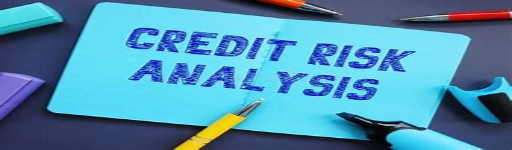


<h1 style="background-color:rgba(153,204,255,0.8);">Import necessary libraries</H1>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support\
,recall_score,precision_score,f1_score
from scipy.stats import f_oneway
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")

<h1 style="background-color:rgba(153,204,255,0.8);">Load the dataset <h1>

In [3]:
a1=pd.read_excel("E:/ames_prediction/case_study1.xlsx")
a2=pd.read_excel("E:/ames_prediction/case_study2.xlsx")

df1 = a1.copy()
df2 = a2.copy()

<h1 style="background-color:rgba(153,204,255,0.8);"> Removing Missing Values <h1>

Nulls in our dataset were denoted by -99999<br>
Nulls were removed

In [101]:
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]
columns_to_be_removed = []
for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)
df2 = df2.drop(columns_to_be_removed, axis =1)
for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]


<h1 style="background-color:rgba(153,204,255,0.8);">Merging DataFrames </h1>

Checking common column names to merge the two dataframes

PROSPECTID is the common column<br>
To Merge the two dataframes , we use inner join so that no nulls are present

In [103]:
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

We check how many columns are categorical

In [104]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


<h1 style="background-color:rgba(153,204,255,0.8);">Feature Selection</h1>

We apply the Chi-square test to find the degree of association between the categorical features and response variable

Ho: There is no association between the variables<br>
H1: There is association between the variables

In [105]:
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)

MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


Since all the categorical features have pval <0.05, we reject H0 at 5% level of significance and conclude that all categorical variable are associated with approved flag

We calculate VIF to check for Multicollinearity in numerical features

In [106]:
numeric_columns = []
for i in df.columns:
    if df[i].dtype != 'object' and i not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(i)

VIF sequentially check<br>
We remove the variables with VIF >6 

In [107]:
vif_data = df[numeric_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0

for i in range (0,total_columns):    
    vif_value = variance_inflation_factor(vif_data, column_index)
    print (column_index,'---',vif_value)
    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1
    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)

0 --- inf
0 --- inf
0 --- 11.320180023967996
0 --- 8.363698035000336
0 --- 6.520647877790928
0 --- 5.149501618212625
1 --- 2.611111040579735
2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477228
2 --- 3.8328007921530785
3 --- 6.099653381646727
3 --- 5.581352009642766
4 --- 1.985584353098778
5 --- inf
5 --- 4.809538302819343
6 --- 23.270628983464636
6 --- 30.595522588100053
6 --- 4.384346405965583
7 --- 3.064658415523423
8 --- 2.898639771299251
9 --- 4.377876915347324
10 --- 2.2078535836958433
11 --- 4.916914200506864
12 --- 5.214702030064725
13 --- 3.3861625024231476
14 --- 7.840583309478997
14 --- 5.255034641721438
15 --- inf
15 --- 7.380634506427232
15 --- 1.421005001517573
16 --- 8.083255010190323
16 --- 1.624122752404011
17 --- 7.257811920140003
17 --- 15.59624383268298
17 --- 1.825857047132431
18 --- 1.5080839450032664
19 --- 2.172088834824577
20 --- 2.623397553527229
21 --- 2.2959970812106167
22 --- 7.360578319196446
22 --- 2.1602387773102554
23 --- 2.8686288267891467
24 ---

In [123]:
print(f"Out of {total_columns} Variables, {len(columns_to_be_kept)} are left")

Out of 72 Variables, 39 are left


Using Anova to find association between the numerical features and Response variable

In [108]:
columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

feature selection is complete

<h4>listing all the final features

In [109]:
features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]

<h1 style="background-color:rgba(153,204,255,0.8);"> Preprocessing </h1>

Label encoding for the categorical features

In [110]:
df['MARITALSTATUS'].unique()    
df['EDUCATION'].unique()
df['GENDER'].unique()
df['last_prod_enq2'].unique()
df['first_prod_enq2'].unique()

array(['PL', 'ConsumerLoan', 'others', 'AL', 'HL', 'CC'], dtype=object)

Ordinal feature -- EDUCATION<br>
SSC            : 1<br>
12TH           : 2<br>
GRADUATE       : 3<br>
UNDER GRADUATE : 3<br>
POST-GRADUATE  : 4<br>
OTHERS         : 1<br>
PROFESSIONAL   : 3<br><br>

Others has to be verified by the business end user 

In [111]:
df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3

In [112]:
df['EDUCATION'].value_counts()
df['EDUCATION'] = df['EDUCATION'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pct_tl_open_L6M            42064 non-null  float64
 1   pct_tl_closed_L6M          42064 non-null  float64
 2   Tot_TL_closed_L12M         42064 non-null  int64  
 3   pct_tl_closed_L12M         42064 non-null  float64
 4   Tot_Missed_Pmnt            42064 non-null  int64  
 5   CC_TL                      42064 non-null  int64  
 6   Home_TL                    42064 non-null  int64  
 7   PL_TL                      42064 non-null  int64  
 8   Secured_TL                 42064 non-null  int64  
 9   Unsecured_TL               42064 non-null  int64  
 10  Other_TL                   42064 non-null  int64  
 11  Age_Oldest_TL              42064 non-null  int64  
 12  Age_Newest_TL              42064 non-null  int64  
 13  time_since_recent_payment  42064 non-null  int

Creating dummy variables for categorical features

In [113]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])
for i in df_encoded.select_dtypes(include=object).columns[:-1]:
    df_encoded[i] = df_encoded[i].astype(int)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_tl_open_L6M               42064 non-null  float64
 1   pct_tl_closed_L6M             42064 non-null  float64
 2   Tot_TL_closed_L12M            42064 non-null  int64  
 3   pct_tl_closed_L12M            42064 non-null  float64
 4   Tot_Missed_Pmnt               42064 non-null  int64  
 5   CC_TL                         42064 non-null  int64  
 6   Home_TL                       42064 non-null  int64  
 7   PL_TL                         42064 non-null  int64  
 8   Secured_TL                    42064 non-null  int64  
 9   Unsecured_TL                  42064 non-null  int64  
 10  Other_TL                      42064 non-null  int64  
 11  Age_Oldest_TL                 42064 non-null  int64  
 12  Age_Newest_TL                 42064 non-null  int64  
 13  t

<h1 style="background-color:rgba(153,204,255,0.8);">Splitting into separate feature variable and Label variable </h5>

In [ ]:
y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )

<h1 style="background-color:rgba(153,204,255,0.8);">label encoding <h1>

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

<h1 style="background-color:rgba(153,204,255,0.8);">Train Test Split </h1>

We split data into Train set and Test set according to 80-20 scheme

In [114]:
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

<h1 style="background-color:rgba(153,204,255,0.8);">Machine Learning model fitting </h1>

<h1 style="background-color:rgba(255, 99, 71, 0.6);">Decision Tree </h1>

In [88]:
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=10)
dt_model.fit(x_train, y_train)

scoring=["accuracy","f1_macro","precision_macro","recall_macro"]
pd.options.display.float_format = '{:,.2f}'.format
cv_scores = pd.DataFrame(cross_validate(dt_model, x_train, y_train, cv=5,scoring=scoring))
cv_scores.drop(columns=["fit_time","score_time"],inplace=True)
cv_scores.columns=scoring

print(f"Cross-validation scores:\n{cv_scores.mean().to_string()}")


Cross-validation scores:
accuracy          0.72
f1_macro          0.63
precision_macro   0.63
recall_macro      0.63


<h1 style="background-color:rgba(255, 99, 71, 0.6);">Random Forest </h1>

In [91]:
rf_classifier = RandomForestClassifier(n_estimators = 200, random_state=42)

scoring=["accuracy","f1_macro","precision_macro","recall_macro"]

cv_scores = pd.DataFrame(cross_validate(rf_classifier, x_train, y_train, cv=5,scoring=scoring))
cv_scores.drop(columns=["fit_time","score_time"],inplace=True)
cv_scores.columns=scoring

print(f"Cross-validation scores:\n{cv_scores.mean().to_string()}")
    

Cross-validation scores:
accuracy          0.77
f1_macro          0.66
precision_macro   0.71
recall_macro      0.64


<h1 style="background-color:rgba(255, 99, 71, 0.6);">xgboost </h1>

In [92]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',  num_class=4)

scoring=["accuracy","f1_macro","precision_macro","recall_macro"]

cv_scores = pd.DataFrame(cross_validate(xgb_classifier, x_train, y_train, cv=5,scoring=scoring))
cv_scores.drop(columns=["fit_time","score_time"],inplace=True)
cv_scores.columns=scoring

print(f"Cross-validation scores:\n{cv_scores.mean().to_string()}")

Cross-validation scores:
accuracy          0.77
f1_macro          0.68
precision_macro   0.70
recall_macro      0.67


xgboost is giving me best results<br><br>
We will further finetune it

<h1 style="background-color:rgba(153,204,255,0.8);">Hyperparameter tuning in xgboost </h1>

In [93]:
# Define the parameter grid for hyperparameter tuning

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

param_grid = {
   'colsample_bytree': [0.1, 0.3, 0.7],
   'learning_rate'   : [0.01, 0.1,0.2],
   'max_depth'       : [3,6,10],
   'alpha'           : [1, 10, 100],
   'n_estimators'    : [100,200,300]
 }

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [1, 10, 100],
                         'colsample_bytree': [0.1, 0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [94]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'alpha': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


<h4>Best Hyperparameters: {'alpha': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}

<h4>Evaluate the model with the best hyperparameters on the test set

In [95]:
best_model = grid_search.best_estimator_

In [99]:
y_pred=best_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print ()
print(f'Accuracy: {accuracy:.2f}')
print ()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()


Accuracy: 0.78

Class p1:
Precision: 0.849615806805708
Recall: 0.7633136094674556
F1 Score: 0.8041558441558442

Class p2:
Precision: 0.8176901605024425
Recall: 0.9290386521308226
F1 Score: 0.8698153474993041

Class p3:
Precision: 0.46578947368421053
Recall: 0.26716981132075474
F1 Score: 0.339568345323741

Class p4:
Precision: 0.7435643564356436
Recall: 0.7298347910592808
F1 Score: 0.7366356056890633



<h1 style="background-color:rgba(153,204,255,0.8);">FInal Accuracy of our model is 0.78 </h1>

<h1 style="background-color:rgba(153,204,255,0.8);">Conclusion </H1>

Based on risk appetite of the bank, we will suggest P1,P2,P3,P4 to the business end user